# 企業違約預測

一般企業違約預測皆使用公司財務指標、總體環境素質來研究企業的違約機率，
這次機器學習則加入了媒體情緒指標，研究企業違約是否也能夠用媒體文字情緒來預測。
使用的變數有
「S&P500指數報酬率(SP500)、
三個月美國國庫券利率(Treasury rate)、
違約距離之過去一年歷史平均(DTDlevel)、
違約距離之趨勢(DTDtrend)、
現金及短期投資與資產市值總額比之過去一年歷史平均(CASH/TAlevel)、
現金及短期投資與資產市值總額比之趨勢(CASH/TAtrend)、
淨收入與資產總額比之過去一年歷史平均(NI/TAlevel)、
淨收入與 資產總額比之趨勢(NI/TAtrend)、
公司規模之過去一年歷史平均(SIZElevel)、
公司規模之趨勢(SIZEtrend)、
普通股權益市值與帳面價值比(M/B)、
獨特性波動(SIGMA)、
媒體情緒指標(MediaSentimentScores)。」

- 安裝套件

In [6]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as sio
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from sklearn import preprocessing, linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, GridSearchCV
sns.set()
sns.set_palette("hls", 8)

- method

1. 輸出模型準確率和繪製混淆矩陣

In [7]:
def output(model,x_train,y_train,S_test) :    
    accuracy_train = model.score(x_train, y_train)
    accuracy_test = model.score(S_test, y_test)
    print("Training Accuracy:",accuracy_train)
    print("Testing Accuracy:",accuracy_test)
    y_pred = model.predict(S_test)
    cm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
    sns.heatmap(cm, 
                xticklabels=['0', '1'],
                yticklabels=['0', '1'],
                annot=True,fmt='g',ax=ax1,
                linewidths=.2,linecolor="Darkblue", cmap="Blues")
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()

# 壹、利用所有變數預測企業違約

# 一、資料處理

## 1. 載入資料集

In [8]:
col = ["ID","Default","SP500","TreasuryRate","DTDLevel","DTDTrend","CashTALevel","CashTATrend"
      ,"NITALevel","NITATrend","SizeLevel","SizeTrend","MB","SIGMA","MediaSentimentScore"]
train = pd.read_excel("2808x15.xlsx",header = None)
train.columns = col
train.head()

,ID,Default,SP500,TreasuryRate,DTDLevel,DTDTrend,CashTALevel,CashTATrend,NITALevel,NITATrend,SizeLevel,SizeTrend,MB,SIGMA,MediaSentimentScore
0,29914,0,0.105748,5.781667,2.991237,-0.304599,0.005914,-0.000994,0.008041,0.003846,-6.169169,0.007151,1.486400,0.036054,1.498164
1,28534,0,0.080355,0.143333,2.774796,-0.190453,0.001935,-0.000613,0.013437,-0.022110,-4.645193,-0.303917,2.358707,0.122560,1.098612
2,30383,0,-0.233859,1.064167,6.639440,-0.426534,0.120863,-0.061333,0.019804,-0.004771,-3.567252,0.001180,1.949723,0.086757,1.386294
3,31500,0,0.060460,3.265000,10.520049,1.675419,0.078752,0.048442,0.067335,-0.002979,-5.213275,-0.050929,7.015260,0.087311,2.079442
4,28432,0,-0.180336,1.369167,7.599402,-2.004519,0.229821,0.028242,0.035658,0.002757,1.685995,-0.024760,5.117003,0.050768,1.194506


In [9]:
test = sio.loadmat("test") 
test = pd.DataFrame(test["new"])
test.columns = col
comp = pd.concat([train,test])
test.head()

,ID,Default,SP500,TreasuryRate,DTDLevel,DTDTrend,CashTALevel,CashTATrend,NITALevel,NITATrend,SizeLevel,SizeTrend,MB,SIGMA,MediaSentimentScore
0,29914.0,0.0,0.061827,0.305167,4.923900,-1.624164,0.015848,0.011049,0.004482,-0.000320,-5.700290,0.033461,0.981776,0.106913,0.597253
1,28534.0,0.0,0.215487,0.034833,5.975118,-2.911236,0.005365,0.002699,0.013425,-0.010326,-3.801586,-0.439577,3.603628,0.095247,0.693147
2,30383.0,0.0,0.212359,0.038667,14.246041,1.020533,0.175501,-0.035221,0.025523,0.006765,-2.506526,-0.029810,3.274125,0.033265,1.945910
3,29443.0,0.0,0.062598,0.025167,1.915331,-0.873294,0.114398,-0.015987,-0.063591,0.057003,-7.290181,-0.896490,1.500431,0.214144,2.754568
4,31264.0,0.0,0.162887,0.050000,3.349041,0.146269,0.196154,0.004205,0.011779,-0.003595,-2.991021,0.159933,1.459570,0.074337,0.366204


## 2. 拆分訓練集、測試集

In [10]:
x = comp.iloc[:,2:]
y = comp.iloc[:,1]

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train , y_test = train_test_split(x, y,test_size=0.2 ,random_state=426)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(2965, 13) (2965,)
(742, 13) (742,)


- 違約與未違約個數

In [12]:
comp.Default.value_counts() 

0.0    3008
1.0     699
Name: Default, dtype: int64

## 3. 資料概覽

- 違約與未違約比例 (訓練集:測試集)

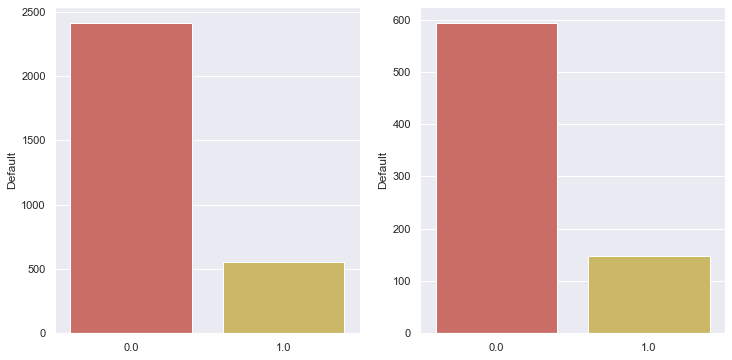

In [13]:
plt.figure(figsize=(12,6))
plt.subplot(121)
dtablefortrain = pd.DataFrame(y_train,columns = ['ID','Default']).Default.value_counts() 
sns.barplot(dtablefortrain.index, dtablefortrain)
plt.subplot(122)
dtablefortest = pd.DataFrame(y_test,columns = ['ID','Default']).Default.value_counts()
sns.barplot(dtablefortest.index, dtablefortest)

- 違約與未違約公司總體環境素質 (訓練集:測試集)

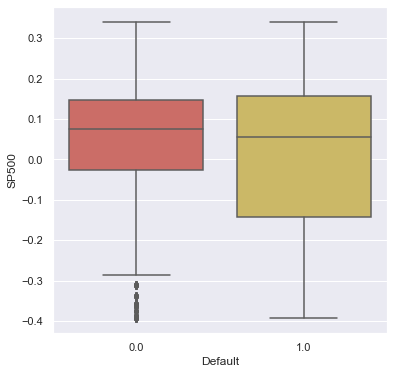

In [14]:
plt.figure(figsize=(6,6))
sns.boxplot("Default" , "SP500" ,data = comp) 

- 違約與未違約公司媒體情指標 (訓練集:測試集)

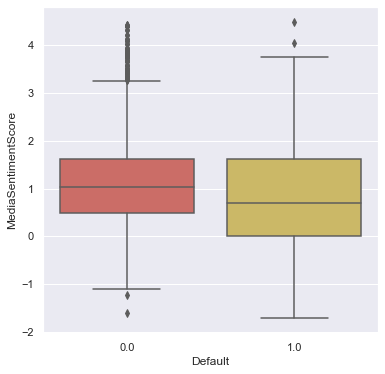

In [15]:
plt.figure(figsize=(6,6))
sns.boxplot("Default" , "MediaSentimentScore" ,data = comp) 

- 公司成長趨勢與媒體情感指標以違約與否分類

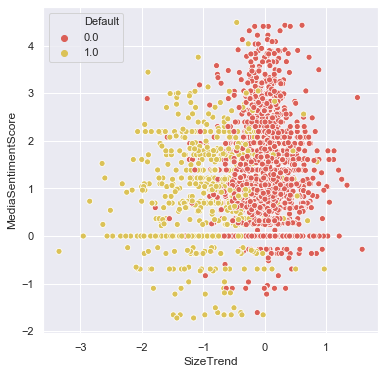

In [16]:
plt.figure(figsize=(6,6))
sns.scatterplot("SizeTrend", "MediaSentimentScore","Default",data=comp)

- 各變數相關性

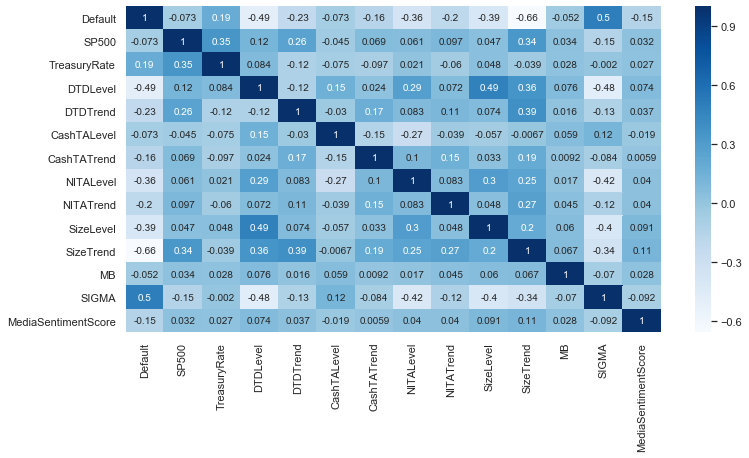

In [17]:
cor = train.iloc[:,1:].corr() 
plt.figure(figsize=(12,6))
sns.heatmap(cor,cmap='Blues',annot=True)

# 二、建立模型

## 1. Logistic

In [18]:
from sklearn import preprocessing, linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [19]:
logistic_regr = linear_model.LogisticRegression(C = 100,penalty='l2',random_state=87, class_weight={0: 0.8, 1: 0.2}, solver='newton-cg')
%time logistic_regr.fit(x_train,y_train)

CPU times: user 84.7 ms, sys: 3.34 ms, total: 88.1 ms
Wall time: 50 ms


LogisticRegression(C=100, class_weight={0: 0.8, 1: 0.2}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=87, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

- 調整參數

In [20]:
logistic=linear_model.LogisticRegression(random_state=87, class_weight={0: 0.8, 1: 0.2}, solver='newton-cg')
hyperparameters={"C":np.logspace(-3,3,7)} 
clf=GridSearchCV(logistic, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 1000.0}


In [21]:
model= linear_model.LogisticRegression(C = 100, penalty='l2', random_state=87) 
scores_accuracy = cross_val_score(model, x_train, y_train, cv=5,scoring='accuracy')
scores_auc = cross_val_score(model, x_train, y_train, cv=5, scoring='roc_auc')
print("Cross-validated scores:", scores_accuracy)
print('average score_accuracy: {}'.format(scores_accuracy.mean()))
print('average score_auc: {}'.format(scores_auc.mean()))

Cross-validated scores: [0.95286195 0.9460371  0.96458685 0.95784148 0.95777027]
average score_accuracy: 0.9558195306298174
average score_auc: 0.9784583827755396


- 混淆矩陣

Training Accuracy: 0.9430016863406409
Testing Accuracy: 0.9393530997304582


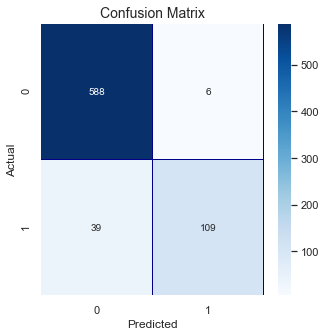

In [22]:
output(logistic_regr,x_train,y_train,x_test)

- 特徵重要性

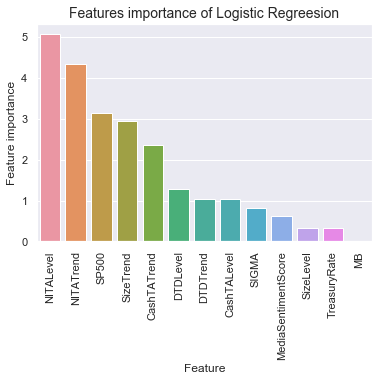

In [23]:
log=np.reshape(abs(logistic_regr.coef_ ), (-1,))
predictors= col[2:]
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': log})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (6,4))
plt.title('Features importance of Logistic Regreesion',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

## 2. SVM

In [24]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', probability=True,random_state=87)

In [25]:
%time svm.fit(x_train,y_train)

CPU times: user 439 ms, sys: 9.47 ms, total: 449 ms
Wall time: 457 ms


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=87,
    shrinking=True, tol=0.001, verbose=False)

- 混淆矩陣

Training Accuracy: 0.9564924114671164
Testing Accuracy: 0.9393530997304582


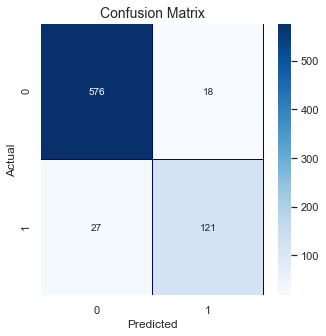

In [26]:
output(svm,x_train,y_train,x_test)

## 3. KNN

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
knn = KNeighborsClassifier(n_neighbors=30)
%time knn.fit(x_train,y_train)

CPU times: user 4.04 ms, sys: 1.53 ms, total: 5.56 ms
Wall time: 14.8 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='uniform')

- 調整參數

In [29]:
KnnClassifier = KNeighborsClassifier(n_neighbors=1)
hyperparameters={"n_neighbors":np.arange(20,100,10)} 
clf=GridSearchCV(KnnClassifier, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'n_neighbors': 30}


- 混淆矩陣

Training Accuracy: 0.9311973018549747
Testing Accuracy: 0.9339622641509434


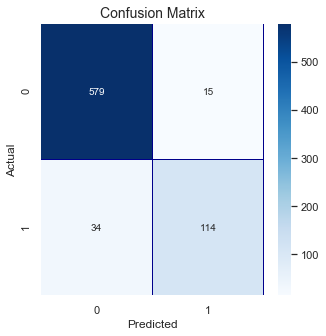

In [30]:
output(knn,x_train,y_train,x_test)

## 4. Random Forest

In [31]:
from sklearn import ensemble

In [32]:
forest = ensemble.RandomForestClassifier(n_estimators = 400, max_features='auto', random_state=87, max_depth=6)
%time forest.fit(x_train,y_train)

CPU times: user 1.45 s, sys: 11.3 ms, total: 1.47 s
Wall time: 1.49 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=87, verbose=0,
                       warm_start=False)

- 調整參數

In [33]:
RandomForestClassifier=ensemble.RandomForestClassifier(max_features='auto', random_state=87)
hyperparameters={"n_estimators":np.arange(100,700,100),
                "max_depth":np.linspace(4,6,3)} 
clf=GridSearchCV(RandomForestClassifier, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'max_depth': 6.0, 'n_estimators': 400}


- 混淆矩陣

Training Accuracy: 0.9716694772344013
Testing Accuracy: 0.9501347708894878


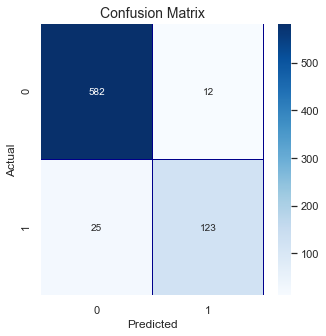

In [34]:
output(forest,x_train,y_train,x_test)

- 特徵重要性

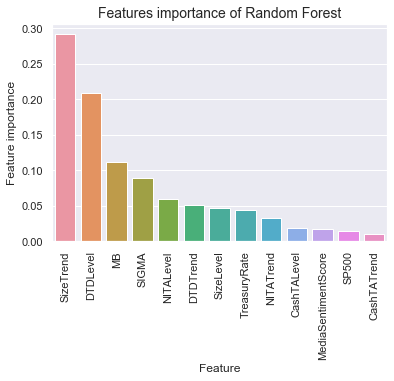

In [35]:
predictors= col[2:]
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': forest.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (6,4))
plt.title('Features importance of Random Forest',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

## 5. XGBOOST

In [36]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost.sklearn import XGBClassifier
from sklearn import metrics

In [37]:
xgb_class = XGBClassifier(random_state=87, n_estimators=60 , max_depth=4, subsample=0.9)
%time xgb_class.fit(x_train,y_train)

CPU times: user 252 ms, sys: 2.96 ms, total: 255 ms
Wall time: 255 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=60, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=87,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

- 調整參數

In [38]:
xGBClassifier= XGBClassifier(random_state=87, subsample=0.9)
hyperparameters={"n_estimators":np.arange(20,100,20),
                 "max_depth" : np.arange(4,6,1)} 
clf=GridSearchCV(xGBClassifier, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'max_depth': 4, 'n_estimators': 60}


In [39]:
import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

Training Accuracy: 0.9811129848229342
Testing Accuracy: 0.954177897574124


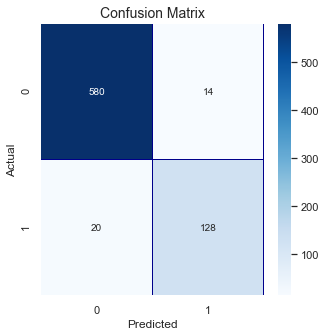

In [40]:
output(xgb_class,x_train,y_train,x_test)

- 特徵重要性

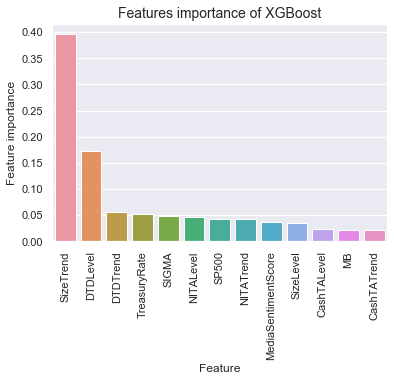

In [41]:
predictors= col[2:]
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': xgb_class.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (6,4))
plt.title('Features importance of XGBoost',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

# 三、模型預測能力

## 1. ROC

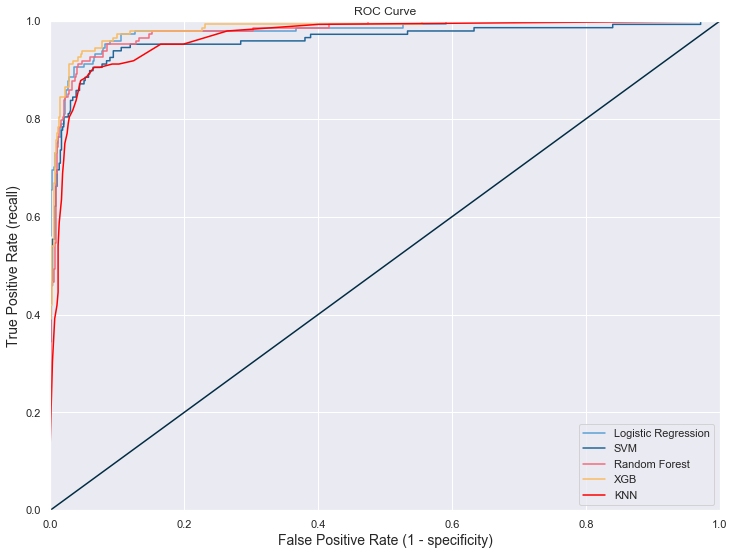

In [42]:
from sklearn.metrics import roc_curve, auc

y_pred_proba1 = logistic_regr.predict_proba(x_test)[:, 1]
[fpr1, tpr1, thr1] = roc_curve(y_test, y_pred_proba1)
plt.figure(figsize=(12,9))
plt.plot(fpr1, tpr1, color='#5ca0d3', label='Logistic Regression')

y_pred_proba2 = svm.predict_proba(x_test)[:, 1]
[fpr2, tpr2, thr2] = roc_curve(y_test, y_pred_proba2)
plt.plot(fpr2, tpr2, color='#226597', label='SVM')

y_pred_proba3 = forest.predict_proba(x_test)[:, 1]
[fpr3, tpr3, thr3] = roc_curve(y_test, y_pred_proba3)
plt.plot(fpr3, tpr3, color='#f36a7b', label='Random Forest')

y_pred_proba4 = xgb_class.predict_proba(x_test)[:, 1]
[fpr4, tpr4, thr4] = roc_curve(y_test, y_pred_proba4)
plt.plot(fpr4, tpr4, color='#fabc60', label='XGB')

y_pred_proba7 = knn.predict_proba(x_test)[:, 1]
[fpr7, tpr7, thr7] = roc_curve(y_test, y_pred_proba7)
plt.plot(fpr7, tpr7, color='#FF0000', label='KNN')

plt.plot([0, 1], [0, 1],color='#022c43')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## 2. AUC

In [43]:
from operator import itemgetter
rocdict = [{'name': "Logistic Regresision", 'AUC': auc(fpr1, tpr1)},
                 {'name': "Random Forest", 'AUC': auc(fpr3, tpr3)},
                 {'name': "SVM", 'AUC': auc(fpr2, tpr2)},
                 {'name': "XGBoost", 'AUC': auc(fpr4, tpr4)}, 
                 {'name': "KNN",'AUC': auc(fpr7, tpr7)},
                ]
rocdict.sort(key=itemgetter('AUC'))
for idx,model in enumerate(rocdict):
    print("AUC of",model["name"],":",model["AUC"])

AUC of SVM : 0.9605571480571481
AUC of KNN : 0.9666427791427791
AUC of Random Forest : 0.9785239785239785
AUC of Logistic Regresision : 0.9795363545363545
AUC of XGBoost : 0.9836768586768586


# 四、小結
可以看出每個模型預測能力皆差不多，總體情緒指標的重要性也偏低。
原因可能是因為財報內容和總體環境素質已足以讓機器學習能夠預測違約，所以媒體文字內容對預測影響不大。
而且其實樣本存在類別不平衡問題，會使機器學習傾向預測多數類別的情形，使型二錯誤上升。
為了解決特徵重要性無法突顯以及類別不平衡問題，接下來使用傾向分數配對來處理資料。

# 貳、利用傾向分數配對(相同財務狀況、總體狀況)

傾向分數配對是將希望固定的自變數對應變數做羅吉斯回歸，羅吉斯回歸輸出結果為機率，例如在此為企業將會違約的機率，而這個機率就叫做傾向分數
，此時我們將傾向分數相同的少數類樣本和多數類樣本做配對，就能配對出違約機率皆相同，但是實際卻情況卻是一個有違約、一個沒有違約的成對樣本，
這樣便可以解決類別不平衡的問題，也能探討加入媒體情緒指標後是否能成功預測違約機率。

# 一、資料處理

## 1. 傾向分數配對

In [46]:
from pymatch.Matcher import Matcher

In [47]:
test = comp[comp["Default"]==1]
control = comp[comp["Default"]==0]

- 傾向分數配對

運用公司財務指標與總體環境素質使用傾向分數配對，意義是將相同財務狀況和總體狀況的違約與未違約樣本配對起來。

In [48]:
m = Matcher(test, control, yvar="Default", exclude=["ID",'MediaSentimentScore'])

Formula:
Default ~ SP500+TreasuryRate+DTDLevel+DTDTrend+CashTALevel+CashTATrend+NITALevel+NITATrend+SizeLevel+SizeTrend+MB+SIGMA
n majority: 3008
n minority: 699


In [49]:
import warnings
warnings.filterwarnings('ignore')
np.random.seed(20170921)
m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 93.56%


In [50]:
m.match(method="min", nmatches=1, threshold=0.0001)
m.record_frequency()

Propensity Scores have not been calculated. Using defaults...
Fitting Models on Balanced Samples: 10\10
Average Accuracy: 93.63%


,freq,n_records
0,1,777
1,2,25
2,3,10
3,4,3
4,5,8
5,6,2
6,7,3
7,8,1
8,9,1
9,10,1


In [51]:
m.assign_weight_vector()

In [52]:
mtest = m.matched_data.sort_values("match_id")

In [53]:
mtest[mtest["Default"]==1].describe()

,record_id,weight,ID,Default,SP500,TreasuryRate,DTDLevel,DTDTrend,CashTALevel,CashTATrend,NITALevel,NITATrend,SizeLevel,SizeTrend,MB,SIGMA,MediaSentimentScore,scores,match_id
count,699.000000,699.0,699.000000,699.0,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,349.000000,1.0,38509.204578,1.0,0.012405,2.903352,0.932806,-0.728808,0.145312,-0.020899,-0.079442,-0.039779,-5.552409,-0.857714,0.869471,0.280060,0.816003,0.898166,349.000000
std,201.928205,0.0,13657.094510,0.0,0.180775,2.109144,1.071320,0.636153,0.192920,0.063403,0.122074,0.133138,1.506288,0.600370,18.319273,0.175181,1.005677,0.196671,201.928205
min,0.000000,1.0,27013.000000,1.0,-0.393149,0.011833,-1.915575,-4.533151,0.000199,-0.401289,-1.359701,-1.151220,-9.728757,-3.348282,-340.063122,0.052238,-1.723067,0.002855,0.000000
25%,174.500000,1.0,31452.000000,1.0,-0.141862,1.000167,0.219481,-1.118909,0.018510,-0.034122,-0.102946,-0.053519,-6.571724,-1.209703,0.126738,0.183859,0.000000,0.916266,174.500000
50%,349.000000,1.0,37055.000000,1.0,0.056611,2.920500,0.826871,-0.654507,0.061368,-0.004004,-0.036240,-0.011885,-5.717377,-0.821696,0.462393,0.240925,0.693147,0.977833,349.000000
75%,523.500000,1.0,43098.500000,1.0,0.156484,4.901667,1.468110,-0.356485,0.193843,0.004798,-0.007789,0.003450,-4.634900,-0.438169,1.090839,0.323604,1.609438,0.995663,523.500000
max,698.000000,1.0,164076.000000,1.0,0.339880,6.008333,6.816453,2.258738,0.961580,0.260453,0.067487,0.764826,1.499231,0.968213,306.693363,1.703276,4.491397,0.999997,698.000000


In [54]:
mtest[mtest["Default"]==0].describe()

,record_id,weight,ID,Default,SP500,TreasuryRate,DTDLevel,DTDTrend,CashTALevel,CashTATrend,NITALevel,NITATrend,SizeLevel,SizeTrend,MB,SIGMA,MediaSentimentScore,scores,match_id
count,699.000000,699.000000,699.000000,699.0,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,2200.409156,0.206009,43194.432046,0.0,0.007612,2.890872,1.019203,-0.646006,0.135505,-0.022056,-0.051272,-0.052366,-5.338323,-0.825641,0.810217,0.295876,0.976657,0.897626,349.000000
std,625.010096,0.312666,19509.524837,0.0,0.150725,1.892391,1.110046,0.632893,0.176818,0.058778,0.157779,0.141293,1.808608,0.504526,11.765685,0.178309,0.869378,0.196426,201.928205
min,771.000000,0.005952,27064.000000,0.0,-0.393149,0.013833,-0.659516,-3.883740,0.002179,-0.350800,-0.998822,-0.644980,-8.319119,-1.913401,-24.463758,0.048751,-0.833961,0.002851,0.000000
25%,1841.000000,0.017544,35445.000000,0.0,-0.110734,0.254167,-0.220221,-0.914791,0.038745,-0.036217,-0.043760,-0.044057,-6.642809,-1.180650,0.175217,0.226242,0.000000,0.916325,174.500000
50%,2175.000000,0.062500,40021.000000,0.0,0.060460,3.265000,0.988640,-0.432342,0.058923,-0.001924,-0.019517,-0.008475,-5.858602,-1.053197,0.419796,0.244332,1.063796,0.979672,349.000000
75%,2468.000000,0.200000,47091.000000,0.0,0.122040,4.473333,1.587415,-0.375216,0.153122,0.000031,-0.018047,0.003151,-4.409596,-0.498848,0.966787,0.328441,1.609438,0.995836,523.500000
max,3669.000000,1.000000,190942.000000,0.0,0.339880,6.008333,7.661529,1.285423,0.942532,0.259871,0.549505,0.141838,0.338177,1.338664,297.562489,1.851365,3.583519,0.995956,698.000000


配對完後可以發現多數類樣本降為699筆，與少數類樣本相同，除了媒體情緒指標，其他變數的概況在兩個類別下都相近。

## 2.訓練集、測試集拆分

In [55]:
x = mtest.iloc[:,4:-2]
y = mtest.iloc[:,3]

In [56]:
x_train, x_test, y_train , y_test = train_test_split(x, y,test_size=0.2 ,random_state=414)
print(x_train.shape, y_train.shape)
print(x_test.shape ,y_test.shape)

(1118, 13) (1118,)
(280, 13) (280,)


# 二、建立模型

## 1. Logistic

In [57]:
logistic_regr = linear_model.LogisticRegression(C = 6,penalty='l2',random_state=87, class_weight={0: 0.5, 1: 0.5}, solver='newton-cg') # model is built in default
%time logistic_regr.fit(x_train,y_train)

CPU times: user 33.3 ms, sys: 2.29 ms, total: 35.6 ms
Wall time: 22.4 ms


LogisticRegression(C=6, class_weight={0: 0.5, 1: 0.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=87, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

- 調整參數

In [58]:
logistic=linear_model.LogisticRegression(random_state=87, class_weight={0: 0.5, 1: 0.5}, solver='newton-cg')
hyperparameters={"C":np.linspace(1,9,9)} 
clf=GridSearchCV(logistic, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 6.0}


In [59]:
model= linear_model.LogisticRegression(C = 6, penalty='l2', random_state=87) 
scores_accuracy = cross_val_score(model, x_train, y_train, cv=5,scoring='accuracy')
scores_auc = cross_val_score(model, x_train, y_train, cv=5, scoring='roc_auc')
print("Cross-validated scores:", scores_accuracy)
print('average score_accuracy: {}'.format(scores_accuracy.mean()))
print('average score_auc: {}'.format(scores_auc.mean()))

Cross-validated scores: [0.53571429 0.46428571 0.54910714 0.58928571 0.58558559]
average score_accuracy: 0.5447956885456886
average score_auc: 0.5992025225432305


- 混淆矩陣

Training Accuracy: 0.5760286225402504
Testing Accuracy: 0.5428571428571428


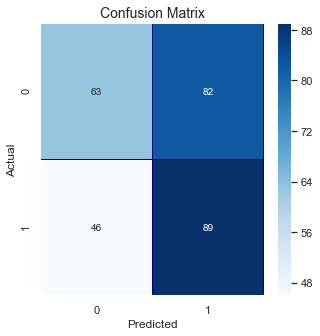

In [60]:
output(logistic_regr,x_train,y_train,x_test)

- 特徵重要性

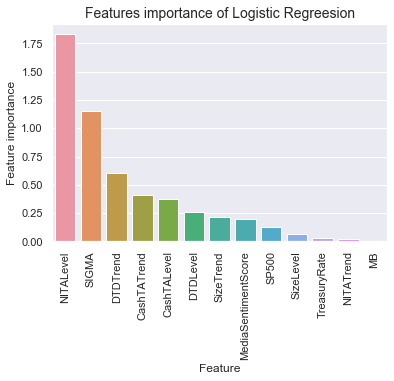

In [61]:
log=np.reshape(abs(logistic_regr.coef_ ), (-1,))
predictors= col[2:]
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': log})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (6,4))
plt.title('Features importance of Logistic Regreesion',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

## 2. SVM 

In [62]:
svm = SVC(kernel='rbf', probability=True,random_state=87)

In [63]:
%time svm.fit(x_train,y_train)

CPU times: user 171 ms, sys: 2.71 ms, total: 173 ms
Wall time: 173 ms


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=87,
    shrinking=True, tol=0.001, verbose=False)

- 混淆矩陣

Training Accuracy: 0.8738819320214669
Testing Accuracy: 0.8607142857142858


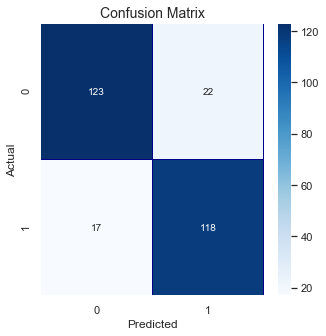

In [64]:
output(svm,x_train,y_train,x_test)

## 3. KNN

In [65]:
knn = KNeighborsClassifier(n_neighbors=40)
%time knn.fit(x_train,y_train)

CPU times: user 2.38 ms, sys: 73 µs, total: 2.45 ms
Wall time: 2.53 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=40, p=2,
                     weights='uniform')

- 調整參數

In [233]:
KnnClassifier = KNeighborsClassifier(n_neighbors=1)
hyperparameters={"n_neighbors":np.arange(20,100,10)} 
clf=GridSearchCV(KnnClassifier, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'n_neighbors': 40}


- 混淆矩陣

Training Accuracy: 0.7772808586762076
Testing Accuracy: 0.7678571428571429


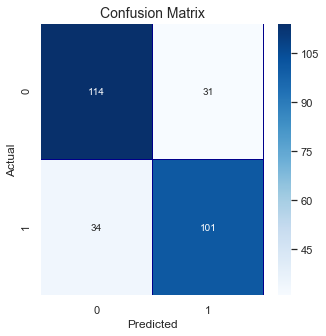

In [66]:
output(knn,x_train,y_train,x_test)

## 4. Random Forest

In [68]:
forest = ensemble.RandomForestClassifier(n_estimators = 400, max_features='auto', random_state=87, max_depth=6)
%time forest.fit(x_train,y_train)

CPU times: user 628 ms, sys: 7.81 ms, total: 636 ms
Wall time: 664 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=87, verbose=0,
                       warm_start=False)

- 調整參數

In [69]:
RandomForestClassifier=ensemble.RandomForestClassifier(max_features='auto', random_state=87)
hyperparameters={"n_estimators":np.arange(100,700,100),
                "max_depth":np.linspace(4,6,3)} 
clf=GridSearchCV(RandomForestClassifier, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'max_depth': 6.0, 'n_estimators': 400}


- 混淆矩陣

Training Accuracy: 0.9785330948121646
Testing Accuracy: 0.925


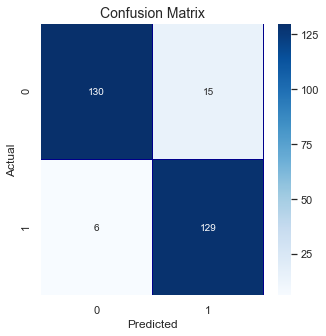

In [70]:
output(forest,x_train,y_train,x_test)

- 特徵重要性

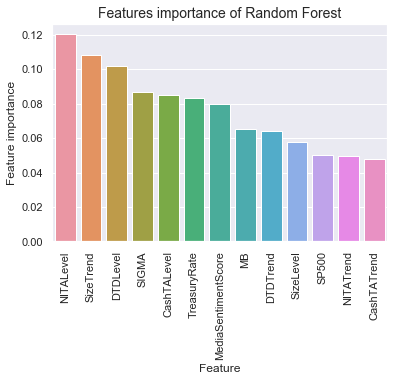

In [71]:
predictors= col[2:]
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': forest.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (6,4))
plt.title('Features importance of Random Forest',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

## 5. XGBOOST

In [72]:
xgb_class = XGBClassifier(random_state=87, n_estimators=80 , max_depth=5, subsample=0.9)
%time xgb_class.fit(x_train,y_train)

CPU times: user 188 ms, sys: 3.57 ms, total: 192 ms
Wall time: 195 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=80, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=87,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

- 調整參數

In [73]:
xGBClassifier= XGBClassifier(random_state=87, subsample=0.9)
hyperparameters={"n_estimators":np.arange(20,100,20),
                 "max_depth" : np.arange(4,6,1)} 
clf=GridSearchCV(xGBClassifier, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'max_depth': 5, 'n_estimators': 80}


- 混淆矩陣

Training Accuracy: 1.0
Testing Accuracy: 0.95


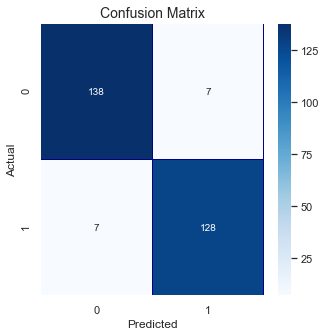

In [74]:
output(xgb_class,x_train,y_train,x_test)

- 特徵重要性

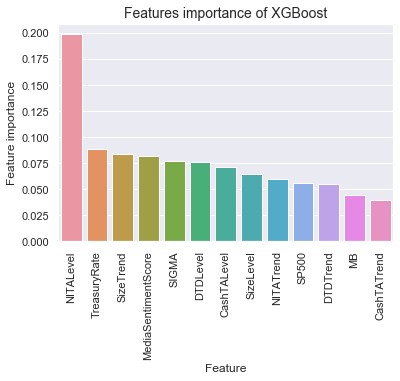

In [242]:
predictors= col[2:]
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': xgb_class.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (6,4))
plt.title('Features importance of XGBoost',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

# 三、模型預測能力

## 1. ROC

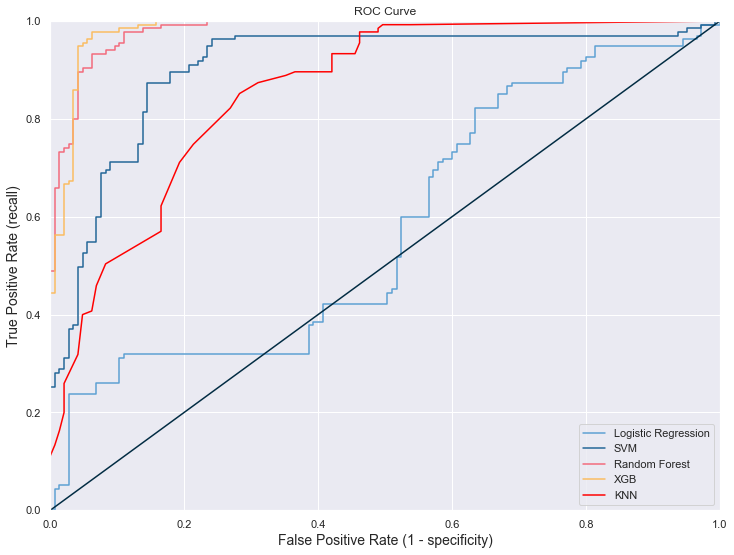

In [75]:
from sklearn.metrics import roc_curve, auc

y_pred_proba1 = logistic_regr.predict_proba(x_test)[:, 1]
[fpr1, tpr1, thr1] = roc_curve(y_test, y_pred_proba1)
plt.figure(figsize=(12,9))
plt.plot(fpr1, tpr1, color='#5ca0d3', label='Logistic Regression')

y_pred_proba2 = svm.predict_proba(x_test)[:, 1]
[fpr2, tpr2, thr2] = roc_curve(y_test, y_pred_proba2)
plt.plot(fpr2, tpr2, color='#226597', label='SVM')

y_pred_proba3 = forest.predict_proba(x_test)[:, 1]
[fpr3, tpr3, thr3] = roc_curve(y_test, y_pred_proba3)
plt.plot(fpr3, tpr3, color='#f36a7b', label='Random Forest')

y_pred_proba4 = xgb_class.predict_proba(x_test)[:, 1]
[fpr4, tpr4, thr4] = roc_curve(y_test, y_pred_proba4)
plt.plot(fpr4, tpr4, color='#fabc60', label='XGB')

y_pred_proba7 = knn.predict_proba(x_test)[:, 1]
[fpr7, tpr7, thr7] = roc_curve(y_test, y_pred_proba7)
plt.plot(fpr7, tpr7, color='#FF0000', label='KNN')

plt.plot([0, 1], [0, 1],color='#022c43')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## 2. AUC

In [76]:
from operator import itemgetter
rocdict = [{'name': "Logistic Regresision", 'AUC': auc(fpr1, tpr1)},
                 {'name': "Random Forest", 'AUC': auc(fpr3, tpr3)},
                 {'name': "SVM", 'AUC': auc(fpr2, tpr2)},
                 {'name': "XGBoost", 'AUC': auc(fpr4, tpr4)}, 
                 {'name': "KNN",'AUC': auc(fpr7, tpr7)},
                ]
rocdict.sort(key=itemgetter('AUC'))
for idx,model in enumerate(rocdict):
    print("AUC of",model["name"],":",model["AUC"])

AUC of Logistic Regresision : 0.5778288633461047
AUC of KNN : 0.8555300127713921
AUC of SVM : 0.9051340996168582
AUC of Random Forest : 0.9809450830140486
AUC of XGBoost : 0.9821711366538953


# 四、小結
在把相似的樣本做配對後，除了屬於集成模型的隨機森林和XGB外，整體的預測能力顯著下降，尤其是羅吉斯回歸，
這是可以預料到的事，畢竟現在所訓練的樣本皆是羅吉斯回歸預測下有類似違約機率的樣本，也就是羅吉斯回歸無法辨認的樣本。在犧牲預測能力後，可以看到媒體情緒指標的重要性有向上提升，但是還是不夠顯著，所以推測其他變數跟媒體情緒指標也許有相關，導致媒體情緒指標的解釋力降低，在考慮第壹部分第一節所做的變數相關性HeatMap後，推測總體環境變數和媒體情緒指標存在共線性問題，下一個部分會將總體變數拔除，並運用集成模型來彌補拔除變數模型預測能力下降的問題。

# 參、傾向分數配對(相同財務狀況)並用集成模型加強預測

# 一、資料處理

## 1. 傾向分數配對

- 傾向分數配對

運用公司財務指標使用傾向分數配對，與上一部份不同的是，這次配對排除總體變數。

In [78]:
m = Matcher(test, control, yvar="Default", exclude=["ID",'MediaSentimentScore',"SP500","TreasuryRate"])

Formula:
Default ~ DTDLevel+DTDTrend+CashTALevel+CashTATrend+NITALevel+NITATrend+SizeLevel+SizeTrend+MB+SIGMA
n majority: 3008
n minority: 699


In [79]:
import warnings
warnings.filterwarnings('ignore')
np.random.seed(20170921)
m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 92.92%


In [80]:
m.match(method="min", nmatches=1, threshold=0.0001)
m.record_frequency()

Propensity Scores have not been calculated. Using defaults...
Fitting Models on Balanced Samples: 10\10
Average Accuracy: 93.0%


,freq,n_records
0,1,805
1,2,23
2,3,12
3,4,4
4,5,7
5,6,5
6,7,1
7,9,1
8,10,5
9,11,2


In [81]:
m.assign_weight_vector()

In [82]:
mtest = m.matched_data.sort_values("match_id")

## 2.訓練集、測試集拆分

In [83]:
x = mtest.iloc[:,6:-2]
y = mtest.iloc[:,3]
x_train, x_test, y_train , y_test = train_test_split(x, y,test_size=0.2 ,random_state=414)
print(x_train.shape, y_train.shape)
print(x_test.shape ,y_test.shape)

(1118, 11) (1118,)
(280, 11) (280,)


# 二、建立單一模型

## 1. Logistic

In [84]:
logistic_regr = linear_model.LogisticRegression(C = 7,penalty='l2',random_state=87, class_weight={0: 0.5, 1: 0.5}, solver='newton-cg') # model is built in default
%time logistic_regr.fit(x_train,y_train)

CPU times: user 40.8 ms, sys: 2.87 ms, total: 43.6 ms
Wall time: 30.1 ms


LogisticRegression(C=7, class_weight={0: 0.5, 1: 0.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=87, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

- 調整參數

In [85]:
logistic=linear_model.LogisticRegression(random_state=87, class_weight={0: 0.5, 1: 0.5}, solver='newton-cg')
hyperparameters={"C":np.linspace(1,9,9)} 
clf=GridSearchCV(logistic, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 7.0}


In [86]:
model= linear_model.LogisticRegression(C = 7, penalty='l2', random_state=87) 
scores_accuracy = cross_val_score(model, x_train, y_train, cv=5,scoring='accuracy')
scores_auc = cross_val_score(model, x_train, y_train, cv=5, scoring='roc_auc')
print("Cross-validated scores:", scores_accuracy)
print('average score_accuracy: {}'.format(scores_accuracy.mean()))
print('average score_auc: {}'.format(scores_auc.mean()))

Cross-validated scores: [0.63111111 0.6875     0.60538117 0.65919283 0.71748879]
average score_accuracy: 0.6601347782760338
average score_auc: 0.7132753328549788


- 混淆矩陣

Training Accuracy: 0.669051878354204
Testing Accuracy: 0.7


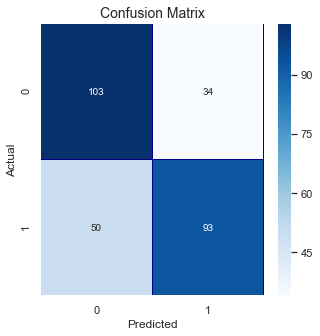

In [87]:
output(logistic_regr,x_train,y_train,x_test)

- 特徵重要度

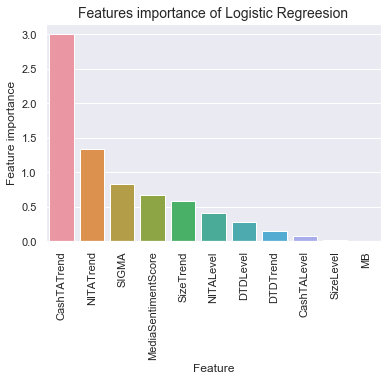

In [282]:
log=np.reshape(abs(logistic_regr.coef_ ), (-1,))
predictors= col[4:]
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': log})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (6,4))
plt.title('Features importance of Logistic Regreesion',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

## 2. SVM 

In [88]:
svm = SVC(kernel='rbf', probability=True,random_state=87)

In [89]:
%time svm.fit(x_train,y_train)

CPU times: user 175 ms, sys: 3.34 ms, total: 178 ms
Wall time: 181 ms


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=87,
    shrinking=True, tol=0.001, verbose=False)

- 混淆矩陣

Training Accuracy: 0.7754919499105546
Testing Accuracy: 0.7821428571428571


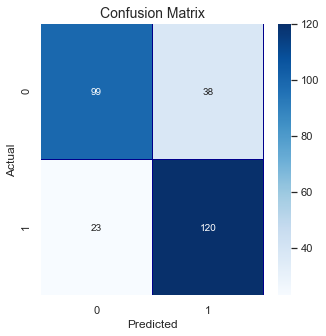

In [90]:
output(svm,x_train,y_train,x_test)

## 3. KNN

In [91]:
knn = KNeighborsClassifier(n_neighbors=90)
%time knn.fit(x_train,y_train)

CPU times: user 2.6 ms, sys: 811 µs, total: 3.41 ms
Wall time: 2.89 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=90, p=2,
                     weights='uniform')

- 調整參數

In [92]:
KnnClassifier = KNeighborsClassifier(n_neighbors=1)
hyperparameters={"n_neighbors":np.arange(20,100,10)} 
clf=GridSearchCV(KnnClassifier, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'n_neighbors': 90}


- 混淆矩陣

Training Accuracy: 0.6762075134168157
Testing Accuracy: 0.6464285714285715


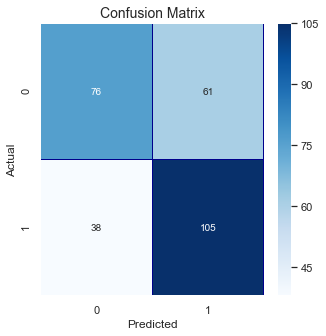

In [93]:
output(knn,x_train,y_train,x_test)

## 4. Random Forest

In [94]:
forest = ensemble.RandomForestClassifier(n_estimators = 600, max_features='auto', random_state=87, max_depth=6)
%time forest.fit(x_train,y_train)

CPU times: user 972 ms, sys: 12.9 ms, total: 985 ms
Wall time: 1.1 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=87, verbose=0,
                       warm_start=False)

- 調整參數

In [95]:
RandomForestClassifier=ensemble.RandomForestClassifier(max_features='auto', random_state=87)
hyperparameters={"n_estimators":np.arange(100,700,100),
                "max_depth":np.linspace(4,6,3)} 
clf=GridSearchCV(RandomForestClassifier, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'max_depth': 6.0, 'n_estimators': 600}


- 混淆矩陣

Training Accuracy: 0.9722719141323792
Testing Accuracy: 0.9035714285714286


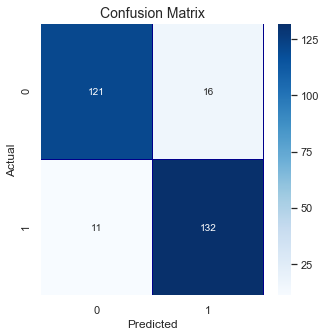

In [96]:
output(forest,x_train,y_train,x_test)

- 特徵重要性

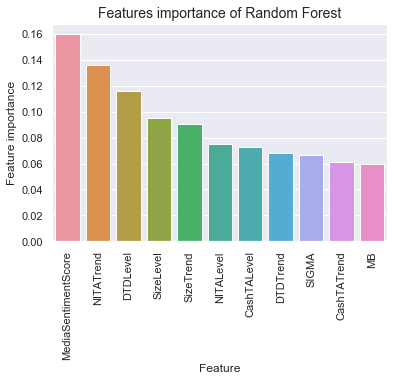

In [97]:
predictors= col[4:]
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': forest.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (6,4))
plt.title('Features importance of Random Forest',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

## 5. XGBOOST

In [98]:
xgb_class = XGBClassifier(random_state=87, n_estimators=80 , max_depth=5, subsample=0.9)
%time xgb_class.fit(x_train,y_train)

CPU times: user 147 ms, sys: 2.36 ms, total: 149 ms
Wall time: 159 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=80, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=87,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

- 調整參數

In [99]:
xGBClassifier= XGBClassifier(random_state=87, subsample=0.9)
hyperparameters={"n_estimators":np.arange(20,100,20),
                 "max_depth" : np.arange(4,6,1)} 
clf=GridSearchCV(xGBClassifier, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(x_train,y_train)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'max_depth': 5, 'n_estimators': 80}


- 混淆矩陣

Training Accuracy: 0.9946332737030411
Testing Accuracy: 0.8892857142857142


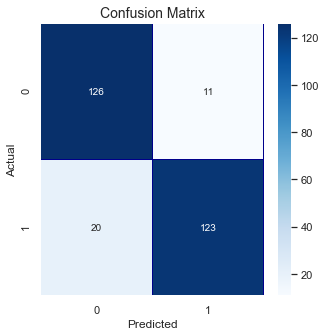

In [100]:
output(xgb_class,x_train,y_train,x_test)

- 特徵重要性

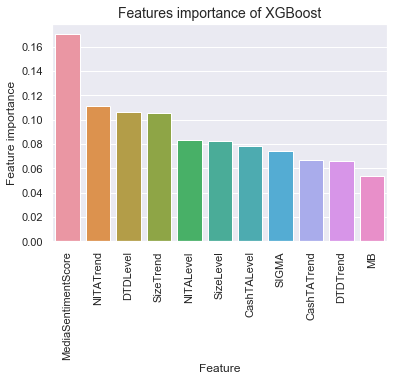

In [101]:
predictors= col[4:]
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': xgb_class.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (6,4))
plt.title('Features importance of XGBoost',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

# 三、各模型相關性

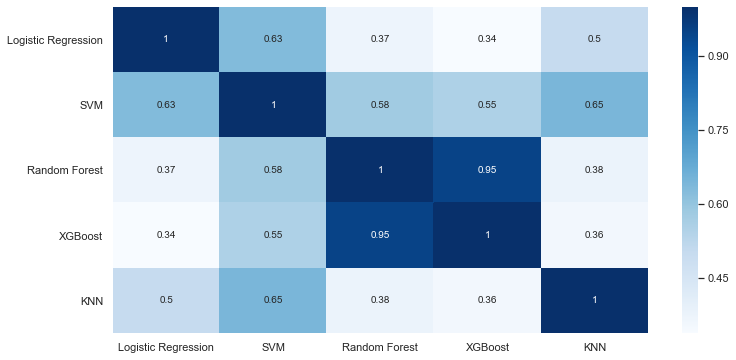

In [102]:
models = {"Logistic Regression":logistic_regr,"SVM":svm,"Random Forest":forest,"XGBoost":xgb_class,"KNN":knn}
def modelcor(modeldict,x):
    predictable = np.zeros((len(x),0))
    for i in modeldict:
        predict = modeldict[i].predict(x)
        predictable = np.column_stack((predictable,predict))
    predictable = pd.DataFrame(predictable)
    predictable.columns = models.keys()
    cor = predictable.corr() 
    plt.figure(figsize=(12,6))
    sns.heatmap(cor,cmap='Blues',annot=True)
modelcor(models,x_train)

選擇三個模型作為之後建立集成模型的第一層預測模型，第一層模型希望各個模型保持較高的準確度，但不希望模型間預測結果太過相近。各個模型中以隨機森林和XGB的預測能力最好，但由於兩者的預測結果相關性太高，所以選擇預測準確率較高的XGB和其他兩個雖然準確率較低但相關性不高的模型(SVM,KNN)作為第一層模型。第二層模型則選擇羅吉斯以防模型過度複雜化所產生過擬合問題。

# 四、建構集成模型

## 1. Stacking

- 第一層模型建構

In [105]:
from vecstack import stacking
stackmodel1st = [    
    SVC(kernel='rbf', probability=True), 
    KNeighborsClassifier(n_neighbors=90), 
    XGBClassifier(random_state=87, n_estimators=80, max_depth=5, subsample=0.9),
]

In [106]:
%time S_train , S_test = stacking(stackmodel1st, x_train, y_train, x_test, regression=False, mode='oof_pred_bag', needs_proba=True, save_dir=None, n_folds=5, stratified=True, shuffle=True, random_state=87, verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [log_loss]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [SVC]
    fold  0:  [0.55596013]
    fold  1:  [0.51813946]
    fold  2:  [0.58511314]
    fold  3:  [0.50146537]
    fold  4:  [0.49876696]
    ----
    MEAN:     [0.53188901] + [0.03353788]
    FULL:     [0.53191977]

model  1:     [KNeighborsClassifier]
    fold  0:  [0.62782296]
    fold  1:  [0.62898729]
    fold  2:  [0.58488233]
    fold  3:  [0.57963441]
    fold  4:  [0.56008060]
    ----
    MEAN:     [0.59628152] + [0.02750311]
    FULL:     [0.59636720]

model  2:     [XGBClassifier]
    fold  0:  [0.22505354]
    fold  1:  [0.19542448]
    fold  2:  [0.26551749]
    fold  3:  [0.23739604]
    fold  4:  [0.22988550]
    ----
    MEAN:     [0.23065541] + [0.02251219]
    FULL:     [0.23061388]

CPU times: user 1.37 s, sys: 26.1 ms, total: 1.4 s
Wall time: 1.7 s


- 第二層模型建構

In [109]:
stackmodel2nd  =linear_model.LogisticRegression(C=100, penalty='l2',random_state=87, solver='newton-cg', class_weight={0: 0.5, 1: 0.5})
%time stackmodel2nd.fit(S_train,y_train)

CPU times: user 19.7 ms, sys: 2.89 ms, total: 22.6 ms
Wall time: 15.8 ms


LogisticRegression(C=100, class_weight={0: 0.5, 1: 0.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=87, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

- 調整參數

In [108]:
loglin = linear_model.LogisticRegression(penalty='l2',random_state=87, solver='newton-cg', class_weight={0: 0.5, 1: 0.5})
hyperparameters={"C":np.logspace(-3,3,7)} 
clf=GridSearchCV(loglin, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(S_train,y_train)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 100.0}


- 混淆矩陣

Training Accuracy: 0.9105545617173524
Testing Accuracy: 0.9178571428571428


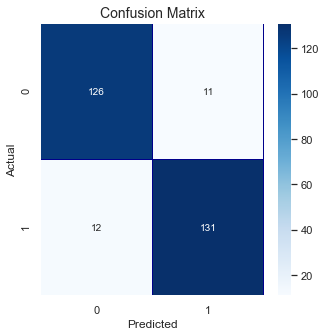

In [110]:
output(stackmodel2nd,S_train,y_train,S_test)

## 2. Blending

- 將訓練集進一步拆分成訓練集與驗證集

驗證集用於通過訓練集所訓練的第一層模型生成特徵，再運用這些特徵來訓練第二層模型。

In [111]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4,random_state=426)
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)                                         

(670, 11) (670,)
(448, 11) (448,)


- 第一層-SVM

In [113]:
bsvm = SVC(kernel='rbf', probability=True)
bsvm.fit(x_train,y_train)
predict_svm = bsvm.predict_proba(x_val)

- 第一層-KNN

In [114]:
bknn = KNeighborsClassifier(n_neighbors=90)
bknn.fit(np.array(x_train),y_train)
predict_knn = bknn.predict_proba(np.array(x_val))

- 第一層-XGBoost

In [115]:
bxgb_class = XGBClassifier(n_estimators=80, random_state=87, max_depth=5, subsample=0.9)
bxgb_class.fit(np.array(x_train),y_train)
predict_xgb = bxgb_class.predict_proba(np.array(x_val))

- 集合驗證集所生成特徵

In [116]:
B_train=np.concatenate((predict_xgb,predict_svm,predict_knn),axis=1)
print(B_train.shape)

(448, 6)


- 測試集經過第一層模型產生特徵

In [117]:
x_test2=np.array(x_test)
test_svm = bsvm.predict_proba(x_test2)
test_xgb = bxgb_class.predict_proba(x_test2)
test_knn = bknn.predict_proba(x_test2)
B_test=np.concatenate((test_xgb,test_svm,test_knn),axis=1)
print(B_test.shape)

(280, 6)


- 第二層-Logistic (驗證集產生特徵訓練)

In [118]:
blogistic_regr= linear_model.LogisticRegression(C=1, penalty='l2',random_state=87, class_weight={0: 0.5, 1: 0.5})
%time blogistic_regr.fit(B_train,y_val)

CPU times: user 1.23 ms, sys: 629 µs, total: 1.86 ms
Wall time: 1.64 ms


LogisticRegression(C=1, class_weight={0: 0.5, 1: 0.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=87, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

- 調整參數

In [120]:
loglinb = linear_model.LogisticRegression(penalty='l2',random_state=87, solver='newton-cg', class_weight={0: 0.5, 1: 0.5})
hyperparameters={"C":np.logspace(-3,3,7)} 
clf=GridSearchCV(loglinb, hyperparameters, cv=5, scoring='recall')
best_model=clf.fit(B_train,y_val)
print("tuned hpyerparameters :(best parameters) ",best_model.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 1.0}


- 混淆矩陣

Training Accuracy: 0.8883928571428571
Testing Accuracy: 0.9


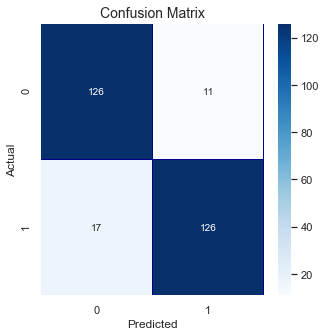

In [121]:
output(blogistic_regr,B_train,y_val,B_test)

# 五、模型預測能力

## 1. ROC

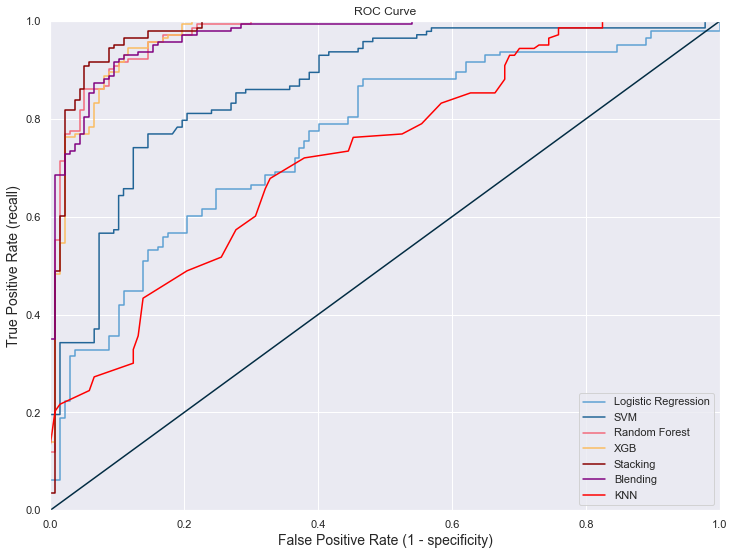

In [122]:
from sklearn.metrics import roc_curve, auc

y_pred_proba1 = logistic_regr.predict_proba(x_test)[:, 1]
[fpr1, tpr1, thr1] = roc_curve(y_test, y_pred_proba1)
plt.figure(figsize=(12,9))
plt.plot(fpr1, tpr1, color='#5ca0d3', label='Logistic Regression')

y_pred_proba2 = svm.predict_proba(x_test)[:, 1]
[fpr2, tpr2, thr2] = roc_curve(y_test, y_pred_proba2)
plt.plot(fpr2, tpr2, color='#226597', label='SVM')

y_pred_proba3 = forest.predict_proba(x_test)[:, 1]
[fpr3, tpr3, thr3] = roc_curve(y_test, y_pred_proba3)
plt.plot(fpr3, tpr3, color='#f36a7b', label='Random Forest')

y_pred_proba4 = xgb_class.predict_proba(x_test)[:, 1]
[fpr4, tpr4, thr4] = roc_curve(y_test, y_pred_proba4)
plt.plot(fpr4, tpr4, color='#fabc60', label='XGB')

y_pred_proba5 = stackmodel2nd.predict_proba(S_test)[:, 1]
[fpr5, tpr5, thr5] = roc_curve(y_test, y_pred_proba5)
plt.plot(fpr5, tpr5, color='#880000', label='Stacking')

y_pred_proba6 = blogistic_regr.predict_proba(B_test)[:, 1]
[fpr6, tpr6, thr6] = roc_curve(y_test, y_pred_proba6)
plt.plot(fpr6, tpr6, color='#800080', label='Blending')

y_pred_proba7 = knn.predict_proba(x_test)[:, 1]
[fpr7, tpr7, thr7] = roc_curve(y_test, y_pred_proba7)
plt.plot(fpr7, tpr7, color='#FF0000', label='KNN')

plt.plot([0, 1], [0, 1],color='#022c43')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## 2. AUC

In [124]:
from operator import itemgetter
rocdict = [{'name': "Logistic Regresision", 'AUC': auc(fpr1, tpr1)},
                 {'name': "Random Forest", 'AUC': auc(fpr3, tpr3)},
                 {'name': "SVM", 'AUC': auc(fpr2, tpr2)},
                 {'name': "XGBoost", 'AUC': auc(fpr4, tpr4)}, 
                 {'name': "KNN",'AUC': auc(fpr7, tpr7)},
                 {'name': "Stacking",'AUC': auc(fpr5, tpr5)},
                 {'name': "Blending",'AUC': auc(fpr6, tpr6)}
                ]
rocdict.sort(key=itemgetter('AUC'))
for idx,model in enumerate(rocdict):
    print("AUC of",model["name"],":",model["AUC"])

AUC of KNN : 0.7240059210862131
AUC of Logistic Regresision : 0.7608595783778265
AUC of SVM : 0.8677453932928386
AUC of XGBoost : 0.9672808942881935
AUC of Blending : 0.967536113521515
AUC of Random Forest : 0.9692205604614363
AUC of Stacking : 0.9743249451278648


# 六、小結

拔除總體環境變數做傾向分數配對後，媒體情緒指標變為最重要的解釋變數，表示在公司財務狀況相近，我們能夠用媒體文字情緒來判斷公司在未來是否會違約，而媒體情緒的內容可能包含了有關總體經濟狀況的一些描述，包括S&P500和無風險利率，使得我們不需要總體變數也能預測企業違約。而集成模型的AUC較單一模型高則可以幫助我們提高預測準確率，並且收斂單一模型所出現的型一、型二錯誤。

# 肆、總結

一開始使用所有樣本做機器學習時，因為類別樣本不平衡問題，機器學習傾嚮將所有樣本預測為未違約，導致型二錯誤的比例皆較高，而在做類似信用違約問題時，我們比較在意的正是型二錯誤的問題，也就是預測沒有違約而實際違約的樣本，因為此類樣本對投資者而言預測錯誤所付出的成本較高。所以在利用傾向分數配對後，解決了樣本的不平衡問題，讓機器學習能夠比較公正的預測樣本是否違約，也可以順道讓樣本有相同的財務體質，使我們可以探討媒體情緒指標在公司財務狀況相似的情況下是否可以有效幫助我們預測企業違約。也因為配對的關係使得樣本數下降以及變數類似化，讓單一模型的預測能力下降，使得預測問題變得更加困難，而使用集成模型面對較複雜的問題時確實能夠提升準確率、收斂錯誤，讓我們在找出媒體情緒指標的影響力後也不失去預測違約的能力。